# **Recomendations:**  
>--Summer weekdays have the worst air quality. If it's due to traffic, reasearch should be done to determine if making public transportation more appealing during summertime can help.   
>--On the geographic-spatial-data vizualization, Redlands, San Bernardino, and Crestline are close to each other. They are the three worst regions. According to Copilot AI they have heavy cargo traffic. Hence, the impact of alternatives, such as cargo by train, should be investigated.  
> --Morever, Redlands, San Bernardino, and Crestline are shipping hubs and that strengthens the hypothosis that traffic is a major contributor. Still, more investigation is needed on other potential reasons, such as manufacturing. Manufacturing could make weekdays worse than weekends as well.  
>The following vizual representations will back up these Summer weekday and region claims.  

all the dates end in 2024  
however, many are fragmented  
The data indicates a sequential patter in the dates that is partitioned within 'Local Site Name', so that is how they shall be filled  

In [45]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
from joblib import dump,load

In [46]:
import plotly.express as px
ozone = pd.read_csv('data/ozone.csv')

In [47]:
print(ozone['Method Code'].isna().sum())
ozone.loc[ozone['Method Code']==53]['Local Site Name'].drop_duplicates(keep='first')

6490


50062    Sequoia & Kings Canyon NPs - Lower Kaweah
50369    Sequoia & Kings Canyon NPs - Ash Mountain
Name: Local Site Name, dtype: object

drop the six locations with fewest observations

In [48]:
under_200_local_observation_regions=[k for k,v in ozone['Local Site Name'].value_counts().items() if v<200]
pre=ozone.shape[0]
ozone=ozone.loc[~ozone['Local Site Name'].isin(under_200_local_observation_regions)].reset_index(drop=True)
post=ozone.shape[0]
print(f"this operation removed {pre-post} rows. That's {round((pre-post)/pre*100)}%")

this operation removed 672 rows. That's 1%


drop 2 columns that won't be used

In [49]:
ozone=ozone.drop(columns=['CBSA Code','CBSA Name'])

### Clean the date column  
It has a lot of fragmented dates and a mix of numeric and text values.  
The data seems to be organized in date sequence. This can be observed by counting missing values such as 1,2,_,_,5,_,6,7.  
Hence values will be filled according to that logic.   


In [50]:
# manually fil index 0
ozone.loc[0,'Date']='01/01/2024'

In [51]:
# replace text month values with numeric. the year is constant so it can be treated in later operations
months = {
    'January': '1',
    'February': '2',
    'March': '3',
    'April': '4',
    'May': '5',
    'June': '6',
    'July': '7',
    'August': '8',
    'September': '9',
    'October': '10',
    'November': '11',
    'December': '12'
}
ozone['Date']=ozone['Date'].astype(str)
#This suffices for now
ozone['Date']=ozone['Date'].apply(lambda x: x if ' ' not in x else months[x.split(' ')[0]]+'/'+''.join(x.split(' ')[1:]) if x.split(' ')[0] in months.keys() else x)

In [52]:
#fill values according to sequence
from datetime import timedelta

questionalble_indicies=[]

def identify(full_or_partial_string_date):
    if len(full_or_partial_string_date)==10:
        return 'no_change'
    elif len(full_or_partial_string_date)==9:
        return 'change_1'
    elif full_or_partial_string_date=='2024':
        return 'change_2'
    elif full_or_partial_string_date=='/2024':
        return 'change_3'
    elif len(full_or_partial_string_date.split('/'))==1 and '2024' not in full_or_partial_string_date:
        return 'change_4'
    elif not full_or_partial_string_date:
        return 'change_5'
#to look at last day of month
last_day_2024 = {    '01': '31',    '02': '29',    '03': '31',    '04': '30',    '05': '31',
        '06': '30',    '07': '31',    '08': '31',    '09': '30',    '10': '31',    '11': '30',    '12': '31'    }  

#LOOP ROW BY ROOW TO KEEP DATE ORDER (BECAUSE PD.TO_DATETIME() RETURNED A LOT OF JANUARY)
for i in range(1,ozone.shape[0]):
    #print(ozone.loc[i,'Date'])
    curr_date=ozone.loc[i,'Date']
    #MOVE ONTO THE NEXT ITERATION IF NO CHANGE IS NEEDED
    if len(curr_date)==10: 
        i+=1
        continue
    curr_local=ozone.loc[i,'Local Site Name']
    prev_local=ozone.loc[i-1,'Local Site Name']
    prev_date=ozone.loc[i-1,'Date']
    if prev_local != curr_local:
        # BUILD A DUMMY PREV
        i2=i
        rows_ahead_of_prev=1
        while len(ozone.loc[i2,'Date'])!=10:
            if i2+1<ozone.shape[0] and ozone.loc[i2+1,'Local Site Name']==curr_local:
                rows_ahead_of_prev+=1
                i2+=1
            else: break
        if len(ozone.loc[i2,'Date'])==10 and ozone.loc[i2,'Local Site Name']==curr_local:
            date=pd.to_datetime(ozone.loc[i2,'Date'],format='%m/%d/%Y')
            new_date=date-timedelta(days=rows_ahead_of_prev)
            curr_date=new_date+timedelta(days=1)
            ozone.loc[i,'Date']=curr_date.strftime('%m/%d/%Y')
            i+=1
            continue

    #GET BASE DATE TO BUILD ON SEQUENTIALY AS HAS BEEN OBSERVED IN THE DATA
    
    if len(prev_date)!=10:
        i2=i
        rows_ahead_of_prev=1
        while len(ozone.loc[i2,'Date'])!=10:
            if i2+1>=ozone.shape[0] and ozone.loc[i2+1,'Local Site Name']==curr_local:
                rows_ahead_of_prev+=1
                i2+=1
            else: break
        if len(ozone.loc[i2,'Date'])==10 and ozone.loc[i2,'Local Site Name']==curr_local:
            date=pd.to_datetime(ozone.loc[i2,'Date'],format='%m/%d/%Y')
            new_date=data-timedelta(days=rows_ahead_of_prev)
            prev_date=new_date.strftime('%m/%d/%Y')
    if len(prev_date)!=10: 
        print(f'index {i-1} is fragmented')
        questionalble_indicies.append(i-1)
        i+=1
        continue

    #PREPARE FILL VALUES BASED ON COMPLETE INTACT PREVIOUS DATE OF SAME LOCAL
    month,day,year=prev_date.split('/')
    
    #CHECK THAT IT'S NOT LAST DAY OF MONTH
    if day==last_day_2024[month]: 
        day='01'
        if month != '12':
            month=str(int(month)+1)
            if len(month)==1: month='0'+month
        else: 
            print(f'indicies {i-1} and {i} have a month discrepancy ie: 12+1')
            questionalble_indicies.append(i)
            year='2025'
            month='01'
            day='01'

    else: day=str(int(day)+1) if len(str(int(day)+1))==2 else '0'+str(int(day)+1)

    #LAMBDA FUNCS THAT IDENTIFY() WILL CALL FROM
    def repair_date_fragment(fragment, month, day):
        change_dict = {
            'no_change': lambda x: x,
            'change_1': lambda x: '0' + x,
            'change_2': lambda x: f'{month}/{day}/{x}',
            'change_3': lambda x: f'{month}/{day}{x}',
            'change_4': lambda x: f'{x}/{day}/2024' if len(x) == 1 else f'0{x}/{day}/2024',
            'change_5': lambda x: f'{month}/{day}/2024'
        }
        #print(i)
        return change_dict[identify(fragment)](fragment)


    ozone.loc[i,'Date']=repair_date_fragment(curr_date, month, day)
    #print(ozone.loc[i,'Date'])
    i+=1

### Converto to datetime

In [53]:
ozone['Date']=pd.to_datetime(ozone['Date'],format='%m/%d/%Y')

### Add "Year," "Month," "Week," and "Season" columns

In [54]:
# Add 'Year', 'Month', and 'Week' columns to the ozone DataFrame using the 'Date' column

ozone['Year'] = ozone['Date'].dt.year
ozone['Month'] = ozone['Date'].dt.month
ozone['Week'] = ozone['Date'].dt.isocalendar().week
ozone['Season']=np.nan
months_in_seasons=[[3,4,5],[6,7,8],[9,10,11],[12,1,2]]
seasons=['Spring','Summer','Autumn','Winter']
for k,v in zip(seasons,months_in_seasons):
    mask=ozone['Month'].isin(v)
    ozone.loc[mask,'Season']=k



### Examine the distribution of the 'Daily Max 8-hour Ozone Concentration' because it will be used throughout to measure ozone quality  

skew: 0.7782970579964431, kurtosis: 1.2460845434759613


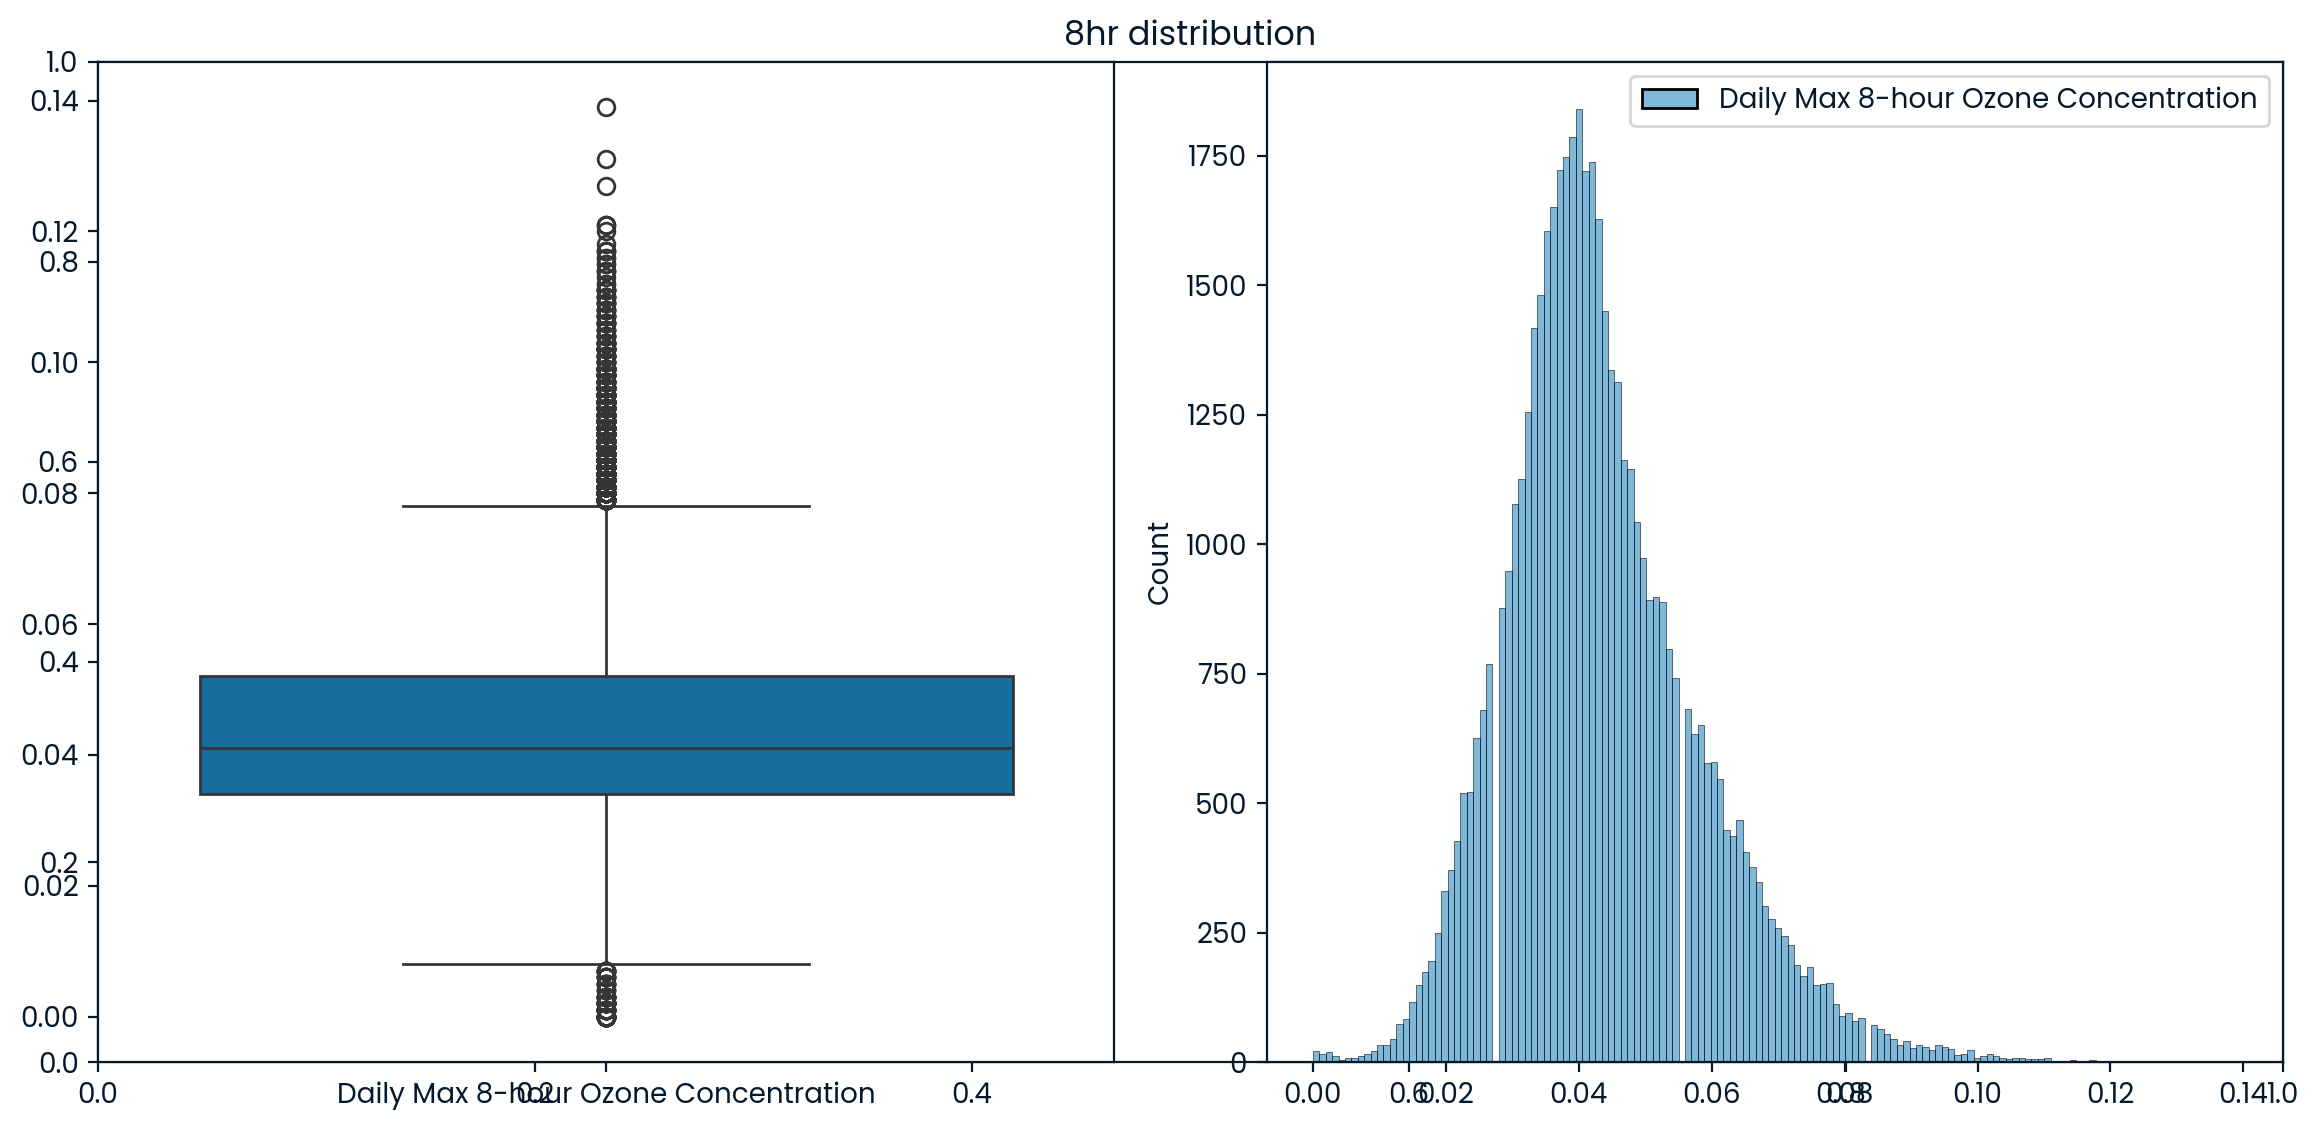

In [55]:

print(f"skew: {ozone['Daily Max 8-hour Ozone Concentration'].skew()}, kurtosis: {ozone['Daily Max 8-hour Ozone Concentration'].kurt()}")
plt.figure(figsize=(12,6))
plt.title('8hr distribution')
plt.subplot(1,2,1)
sns.boxplot(ozone[['Daily Max 8-hour Ozone Concentration']])
plt.subplot(1,2,2)
sns.histplot(ozone[['Daily Max 8-hour Ozone Concentration']])
plt.tight_layout()
plt.show()

# Identify Geographic hierarchy  
### *'County' > 'Local Site Name'*

sort the data and then look at position of NaNs 

In [56]:
# for i in ['County' , 'County FIPS Code' , 'CBSA Name' , 'Local Site Name']: print(len[ozone[i].unique())
ozone=ozone.sort_values(by=['County' , 'County FIPS Code' , #'CBSA Name' , 
                            'Local Site Name','Date'],ascending=True).reset_index(drop=True)


In [57]:
#get an idea how close NaNs are to each other by compating index locations
nan_rows=['Daily Max 8-hour Ozone Concentration','Daily AQI Value']
def examine_nan_sequentially(data,col):
    nan_df=data.copy()
    nan_df=nan_df.loc[nan_df[col].isna()]
    nan_df['lag-index']=nan_df.index.to_series().shift(1)
    mask=abs(nan_df.index-nan_df['lag-index'])<=1
    display(nan_df.loc[mask])
for col in nan_rows:
    examine_nan_sequentially(ozone,col)
    continue


Date  Source   Site ID  POC  ...  Month Week  Season lag-index
67    2024-06-06  AirNow  60010013    1  ...      6   23  Summer      66.0
330   2024-06-05  AirNow  60012001    1  ...      6   23  Summer     329.0
1506  2024-12-30     AQS  60050002    1  ...     12    1  Winter    1505.0
1829  2024-11-23     AQS  60070008    1  ...     11   47  Autumn    1828.0
1877  2024-01-10     AQS  60072003    1  ...      1    2  Winter    1876.0
...          ...     ...       ...  ...  ...    ...  ...     ...       ...
50874 2024-03-14     AQS  61072003    1  ...      3   11  Spring   50873.0
51267 2024-04-08     AQS  61090005    1  ...      4   15  Spring   51266.0
51268 2024-04-09     AQS  61090005    1  ...      4   15  Spring   51267.0
53603 2024-09-04     AQS  61130004    1  ...      9   36  Autumn   53602.0
54051 2024-11-26     AQS  61131003    1  ...     11   48  Autumn   54050.0

[145 rows x 20 columns]

Date  Source   Site ID  POC  ...  Month Week  Season lag-index
19    2024-04-11  AirNow  60010013    1  ...      4   15  Spring      18.0
525   2024-03-13  AirNow  60010009    1  ...      3   11  Spring     524.0
1374  2024-08-23     AQS  60050002    1  ...      8   34  Summer    1373.0
1920  2024-02-24     AQS  60072003    1  ...      2    8  Winter    1919.0
3039  2024-05-08  AirNow  60131002    1  ...      5   19  Spring    3038.0
...          ...     ...       ...  ...  ...    ...  ...     ...       ...
52133 2024-08-19     AQS  61111004    1  ...      8   34  Summer   52132.0
52196 2024-10-21     AQS  61111004    1  ...     10   43  Autumn   52195.0
53201 2024-07-19     AQS  61110007    1  ...      7   29  Summer   53200.0
53275 2024-10-01     AQS  61110007    1  ...     10   40  Autumn   53274.0
53897 2024-06-26     AQS  61131003    1  ...      6   26  Summer   53896.0

[139 rows x 20 columns]

Examine distribution of NaN columns

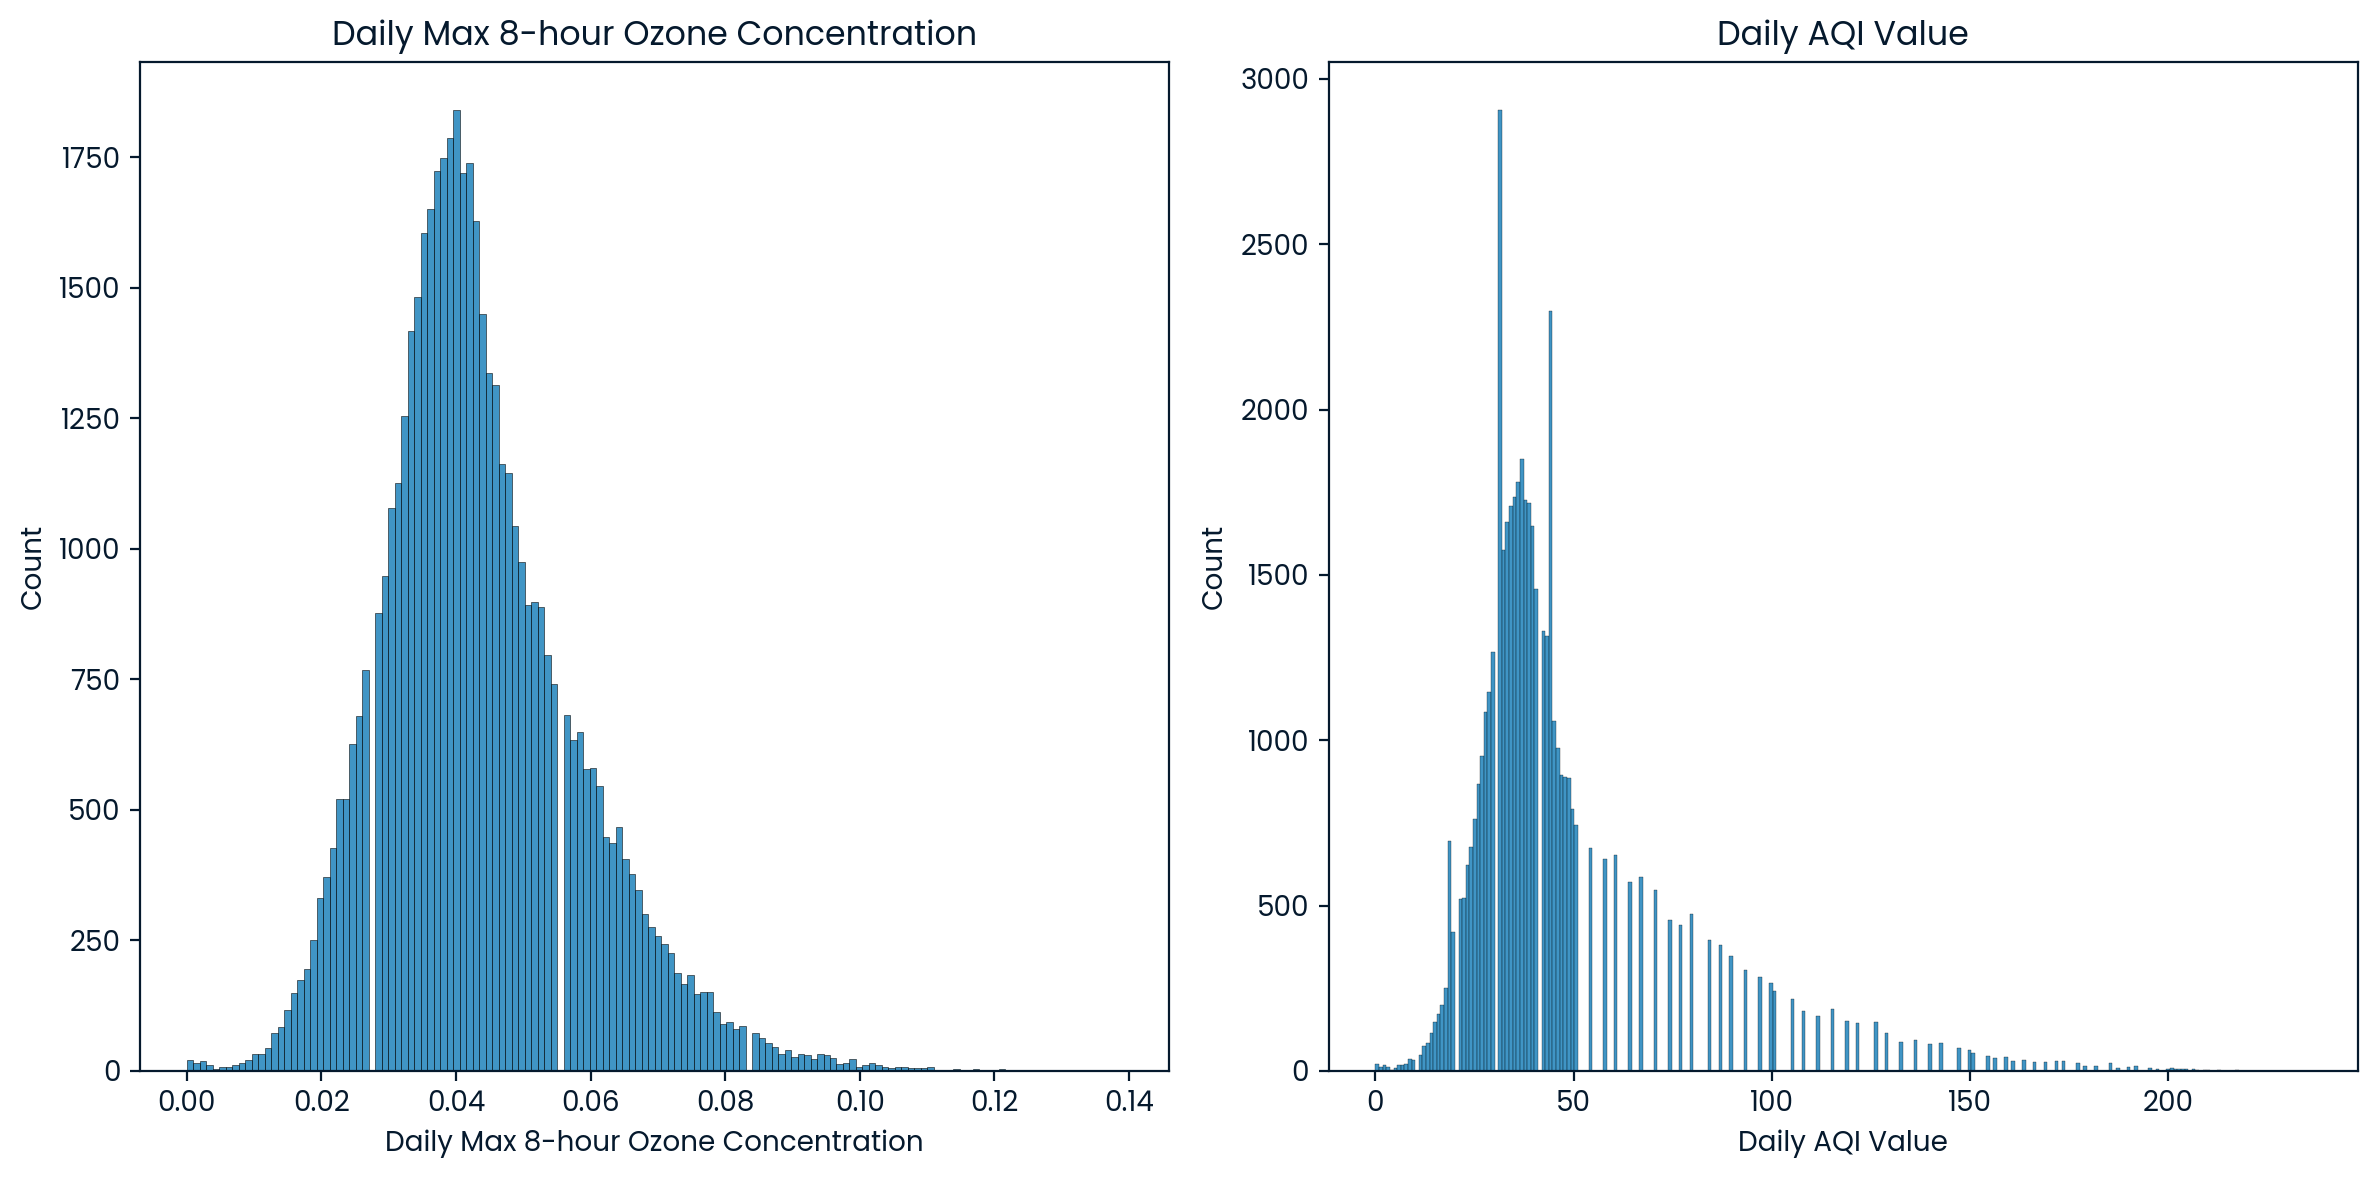

In [58]:
X=ozone[['Daily Max 8-hour Ozone Concentration','Daily AQI Value']]
plt.figure(figsize=(12,6))
p=1
for i in X.columns:
    plt.subplot(1,2,p)
    sns.histplot(X[i])
    plt.title(i)
    p+=1
plt.tight_layout()
plt.show()

<Axes: ylabel='Daily AQI Value'>

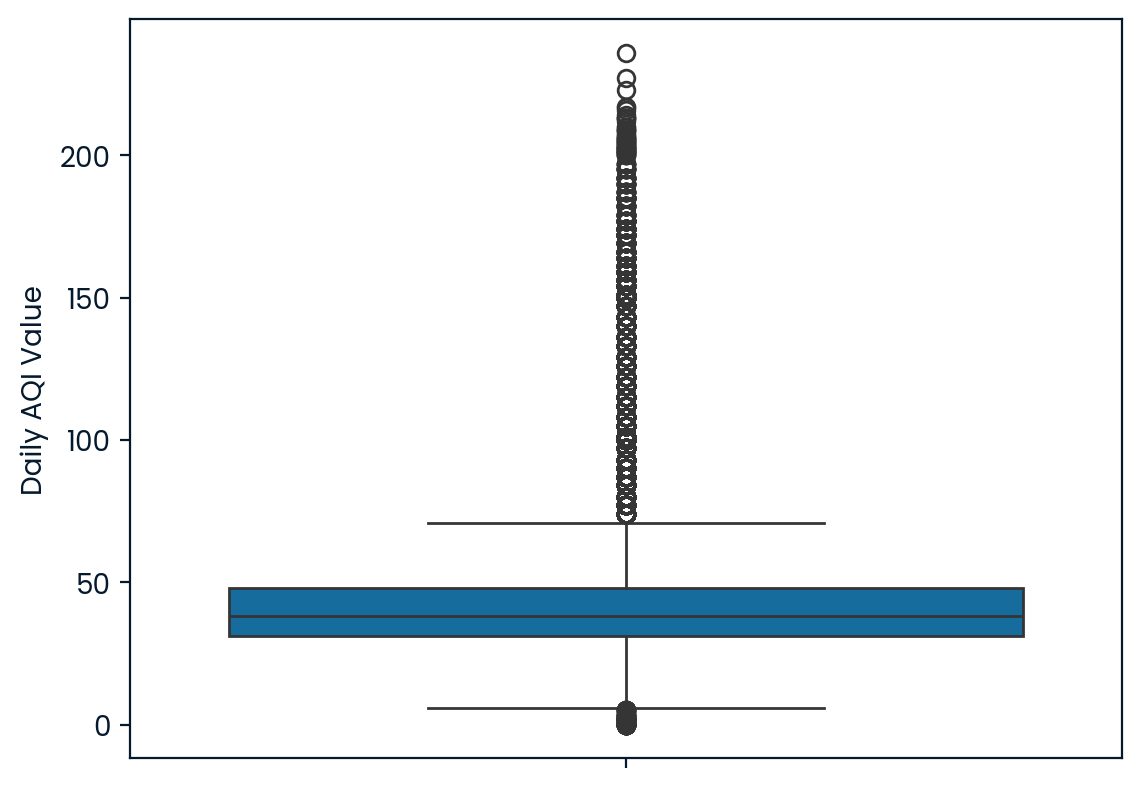

In [59]:
sns.boxplot(X['Daily AQI Value'])

- use predictive models to fill NaNs

NaN fill model r2 scores:  0.8745190691978961 0.8745143933896251  
Determination: this will do 

In [60]:
#cap,floor, normalize
q1=ozone['Daily Max 8-hour Ozone Concentration'].quantile(0.25)
q3=q1=ozone['Daily Max 8-hour Ozone Concentration'].quantile(0.75)
iqr=q3=q1
l=q1-1.5*iqr
u=q3+1.5*iqr
ozone['8hr_capped_floored']=ozone['Daily Max 8-hour Ozone Concentration'].clip(lower=l,upper=u)
mean=ozone['Daily Max 8-hour Ozone Concentration'].mean()
std=ozone['Daily Max 8-hour Ozone Concentration'].std()
ozone['8hr_normalized']=(ozone['Daily Max 8-hour Ozone Concentration']-mean)/std
q1=np.quantile(ozone['Daily AQI Value'],.25)
q3=np.quantile(ozone['Daily AQI Value'],.75)
iqr=q3-q1
upper=q3+iqr*1.5
lower=q1-iqr*1.5
ozone['capped_floored_AQI']=ozone['Daily AQI Value'].clip(lower,upper)
mean=ozone['capped_floored_AQI'].mean()
std=ozone['capped_floored_AQI'].std()
ozone['AQI_normalized']= (ozone['capped_floored_AQI'] - mean) / std

model1=joblib.load("x_8hr_y_AQI_fill_y.pkl")
model2=joblib.load("x_AQI_y_8hr_fill_y.pkl")

ozone['Daily AQI Value'] = ozone.apply(
    lambda row: row['Daily AQI Value'] if not pd.isna(row['Daily AQI Value']) else model1.predict([[row['8hr_normalized']]])[0] if not pd.isna(row['Daily Max 8-hour Ozone Concentration']) else np.nan,
    axis=1
)
ozone['Daily Max 8-hour Ozone Concentration'] = ozone.apply(
    lambda row: row['Daily Max 8-hour Ozone Concentration'] if not pd.isna(row['Daily Max 8-hour Ozone Concentration']) else model2.predict([[row['AQI_normalized']]])[0] if not pd.isna(row['Daily AQI Value']) else np.nan,
    axis=1
)


some rows had multiple NaNs and couln't be predicted so a second approach is added

In [61]:
ozone.loc[(ozone['Daily Max 8-hour Ozone Concentration'].isna())&(ozone['Daily AQI Value'].isna())].shape

(135, 23)

use 2 days to determine the fill value: one is 7 ahead, the other is 7 behind. 

In [62]:
ozone=ozone.sort_values(by=['Local Site Name','Date']).reset_index(drop=True)
nan_rows=['Daily Max 8-hour Ozone Concentration']
subset_col='Local Site Name'
def seasonal_interp_fill(data,subset,target):
    for sub in list(data[subset].unique()):
        set=data.loc[data[subset]==sub]
        mn=set.index.min()
        mx=set.index.max()
        nan_indexes=set.loc[set[target].isna()].index
        if len(nan_indexes)>0: 
            for i in nan_indexes:
                if abs(i-mn)>=7:
                    if abs(i-mx)>=7 and not pd.isna(data.loc[i-7,target]) and not pd.isna(data.loc[i+7,target]):
                        fill_val=(data.loc[i-7,target]+data.loc[i+7,target])/2
                        data.loc[i,target]=fill_val
                        continue
                    elif abs(i-mn)>=14 and not pd.isna(data.loc[i-7,target]) and not pd.isna(data.loc[i-14,target]):
                        fill_val=(data.loc[i-7,target]+data.loc[i-14,target])/2
                        data.loc[i,target]=fill_val
                        continue
                    else:
                        continue
                elif abs(i-mx)>=14 and not pd.isna(data.loc[i+7,target]) and not pd.isna(data.loc[i+14,target]):
                    fill_val=(data.loc[i+7,target]+data.loc[i+14,target])/2
                    data.loc[i,target]=fill_val
                    continue
                else:
                    continue
    
    return data
for targ in nan_rows:
    ozone=seasonal_interp_fill(ozone,subset_col,targ)


use recently filled values to fill the remainder

In [63]:
q1=ozone['Daily Max 8-hour Ozone Concentration'].quantile(0.25)
q3=q1=ozone['Daily Max 8-hour Ozone Concentration'].quantile(0.75)
iqr=q3=q1
l=q1-1.5*iqr
u=q3+1.5*iqr
ozone['8hr_capped_floored']=ozone['Daily Max 8-hour Ozone Concentration'].clip(lower=l,upper=u)
mean=ozone['Daily Max 8-hour Ozone Concentration'].mean()
std=ozone['Daily Max 8-hour Ozone Concentration'].std()
ozone['8hr_normalized']=(ozone['Daily Max 8-hour Ozone Concentration']-mean)/std
q1=np.quantile(ozone['Daily AQI Value'],.25)
q3=np.quantile(ozone['Daily AQI Value'],.75)
iqr=q3-q1
upper=q3+iqr*1.5
lower=q1-iqr*1.5
ozone['capped_floored_AQI']=ozone['Daily AQI Value'].clip(lower,upper)
mean=ozone['capped_floored_AQI'].mean()
std=ozone['capped_floored_AQI'].std()
ozone['AQI_normalized']= (ozone['capped_floored_AQI'] - mean) / std

model1=joblib.load("x_8hr_y_AQI_fill_y.pkl")
model2=joblib.load("x_AQI_y_8hr_fill_y.pkl")

ozone['Daily AQI Value'] = ozone.apply(
    lambda row: row['Daily AQI Value'] if not pd.isna(row['Daily AQI Value']) else model1.predict([[row['8hr_normalized']]])[0] if not pd.isna(row['Daily Max 8-hour Ozone Concentration']) else np.nan,
    axis=1
)
ozone['Daily Max 8-hour Ozone Concentration'] = ozone.apply(
    lambda row: row['Daily Max 8-hour Ozone Concentration'] if not pd.isna(row['Daily Max 8-hour Ozone Concentration']) else model2.predict([[row['AQI_normalized']]])[0] if not pd.isna(row['Daily AQI Value']) else np.nan,
    axis=1
)


In [64]:
ozone.isna().sum()

Date                                       0
Source                                     0
Site ID                                    0
POC                                        0
Daily Max 8-hour Ozone Concentration       0
Units                                      0
Daily AQI Value                            0
Local Site Name                            0
Daily Obs Count                            0
Percent Complete                           0
Method Code                             6150
County FIPS Code                           0
County                                     0
Site Latitude                              0
Site Longitude                             0
Year                                       0
Month                                      0
Week                                       0
Season                                     0
8hr_capped_floored                         0
8hr_normalized                             0
capped_floored_AQI                       135
AQI_normal

### Day of the Week Columns:   
{0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

In [65]:
ozone['Date'] = pd.to_datetime(ozone['Date'])
day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
ozone['Day_of_Week'] = ozone['Date'].dt.dayofweek.map(day_dict)

predict categorical NaN fill values

In [66]:
ozone['Method Code'].unique()
labels={47.:0,87.:2, 199.:3,  53.:1}
ozone['Method_Labels']=ozone['Method Code'].apply(lambda x: labels[x] if not pd.isna(x) else np.nan)

In [67]:
ozone['Local Site Name'] = ozone['Local Site Name'].str.strip()
locals = list(ozone['Local Site Name'].unique())
location_keys = {k.strip(): v for v, k in enumerate(locals)}
ozone['Location_coded']=ozone['Local Site Name'].map(location_keys)

In [68]:

from sklearn.metrics import f1_score
"""
from sklearn.ensemble import RandomForestClassifier

X=ozone[['Location_coded','Method_Labels']]
X=X.dropna()
X=X.sample(frac=1,random_state=43)
slice=(X.shape[0]//4)*3

y_train=X['Method_Labels'][:slice]
y_test=X['Method_Labels'][slice:]

X_train=X.iloc[:slice,:]
X_train=X_train.drop(columns='Method_Labels')

X_test=X.iloc[slice:,:]
X_test=X_test.drop(columns='Method_Labels')

top_score=-float('inf')
best=None
model=RandomForestClassifier()
model.fit(X_train,y_train)

joblib.dump(model,"x_location_coded_y_method_labels_y_fill.pkl")
"""
model=joblib.load("x_location_coded_y_method_labels_y_fill.pkl")

    

In [69]:
mask=ozone['Method Code'].isna()
ozone.loc[mask,'Method_Labels']=model.predict(ozone.loc[mask][['Location_coded']])

In [70]:
labels={47.:0,87.:2, 199.:3,  53.:1}
reverse_labels={v:k for k,v in labels.items()}
mask=ozone['Method Code'].isna()
ozone.loc[mask,'Method Code']=ozone.loc[mask,'Method_Labels'].map(reverse_labels)


# Missing value counts  
the table below shows that there are none

In [71]:
ozone=ozone.drop(columns=['capped_floored_AQI','AQI_normalized'])

In [72]:
ozone.isna().sum()

Date                                    0
Source                                  0
Site ID                                 0
POC                                     0
Daily Max 8-hour Ozone Concentration    0
Units                                   0
Daily AQI Value                         0
Local Site Name                         0
Daily Obs Count                         0
Percent Complete                        0
Method Code                             0
County FIPS Code                        0
County                                  0
Site Latitude                           0
Site Longitude                          0
Year                                    0
Month                                   0
Week                                    0
Season                                  0
8hr_capped_floored                      0
8hr_normalized                          0
Day_of_Week                             0
Method_Labels                           0
Location_coded                    

the rest of the notebook loads this as data file, but it can be renamed to 'df' instead

In [73]:
#mostly_cleaned_ozone=ozone.copy()
#mostly_cleaned_ozone.to_csv('mostly_cleaned_ozone.csv',index=False)

create a function to give preliminary overviews

In [74]:
# a function to give preliminary overviews

import matplotlib.pyplot as plt
import seaborn as sns

def plot_and_df(data,y,X,sort=None,title=None):
    if not sort: sort=X
    pd.set_option('display.width',1000)
    grouped_data=data.groupby(X,as_index=False)[y].mean()  
    grouped_data=grouped_data.sort_values(by=sort).reset_index(drop=True)
    display(grouped_data.T.style.set_table_styles([ 
                       {"selector": ".col_heading","props":[("background-color", "#0E3AA8"), ("color", "white"),("border", "3px solid black")]},  
            {"selector": ".row_heading", "props": [("background-color", "#0E3AA8"), ("color", "white"),("border", "3px solid black")]}, 
            {"selector": "td", "props": [("background-color", "#4D7BED"), ("color", "white"),("border", "3px solid black")]}, 
            {"selector": "th.blank","props": [ ("background-color", "#0E3AA8"), ("color", "white"),("text-align", "center"),("border", "3px    solid black")]}]) 
)
    plt.style.use('seaborn-v0_8-colorblind')     
    plot_data=grouped_data.copy()
    plot_data=plot_data.sort_values(by=sort).reset_index(drop=True)
    plot_x='|'.join(X)
    plot_data[plot_x]=plot_data['|'.join(X)] = plot_data[X].astype(str).agg('|'.join, axis=1)
    plt.figure(figsize=(20,7))
    plt.subplot(1,1,1)
    plt.title(title)
    sns.lineplot(x=plot_data[plot_x],y=plot_data[y])
    plt.grid()
    plt.show()

### The lineplot below gives an idea of how the 8hr concentrations varies across site locations

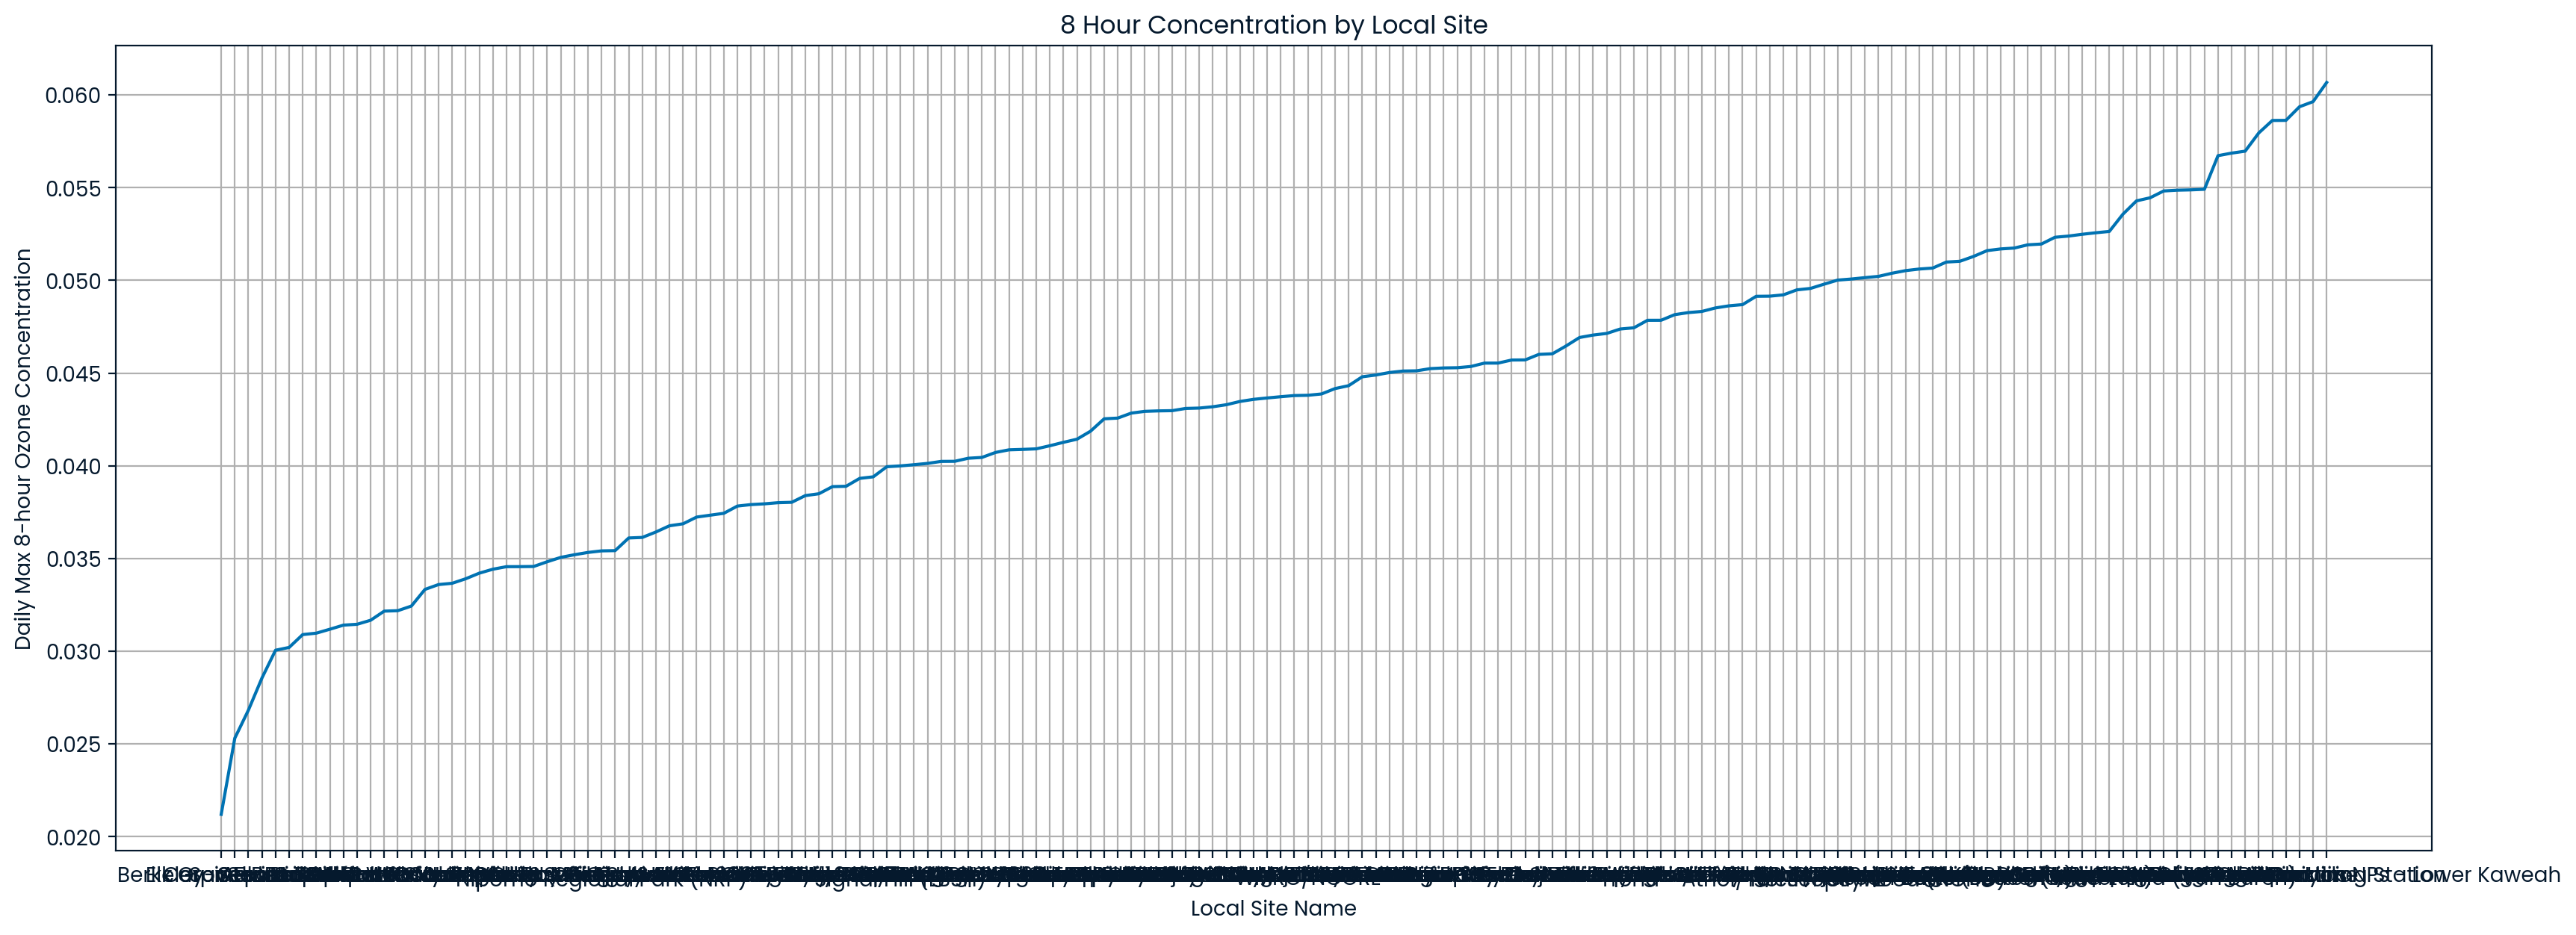

In [75]:
y=[ 'Daily Max 8-hour Ozone Concentration']
region_8hr=['Local Site Name']
ozone=ozone.sort_values(by='Daily Max 8-hour Ozone Concentration')
plot_and_df(ozone,'Daily Max 8-hour Ozone Concentration',region_8hr,sort=y,title='8 Hour Concentration by Local Site')

### The next lineplot looks at bigger geographic regions [Autumn, Spring, Summer, Winter] and includes time components within each partition.  
### Note that the seasons are not ordered in sequence 

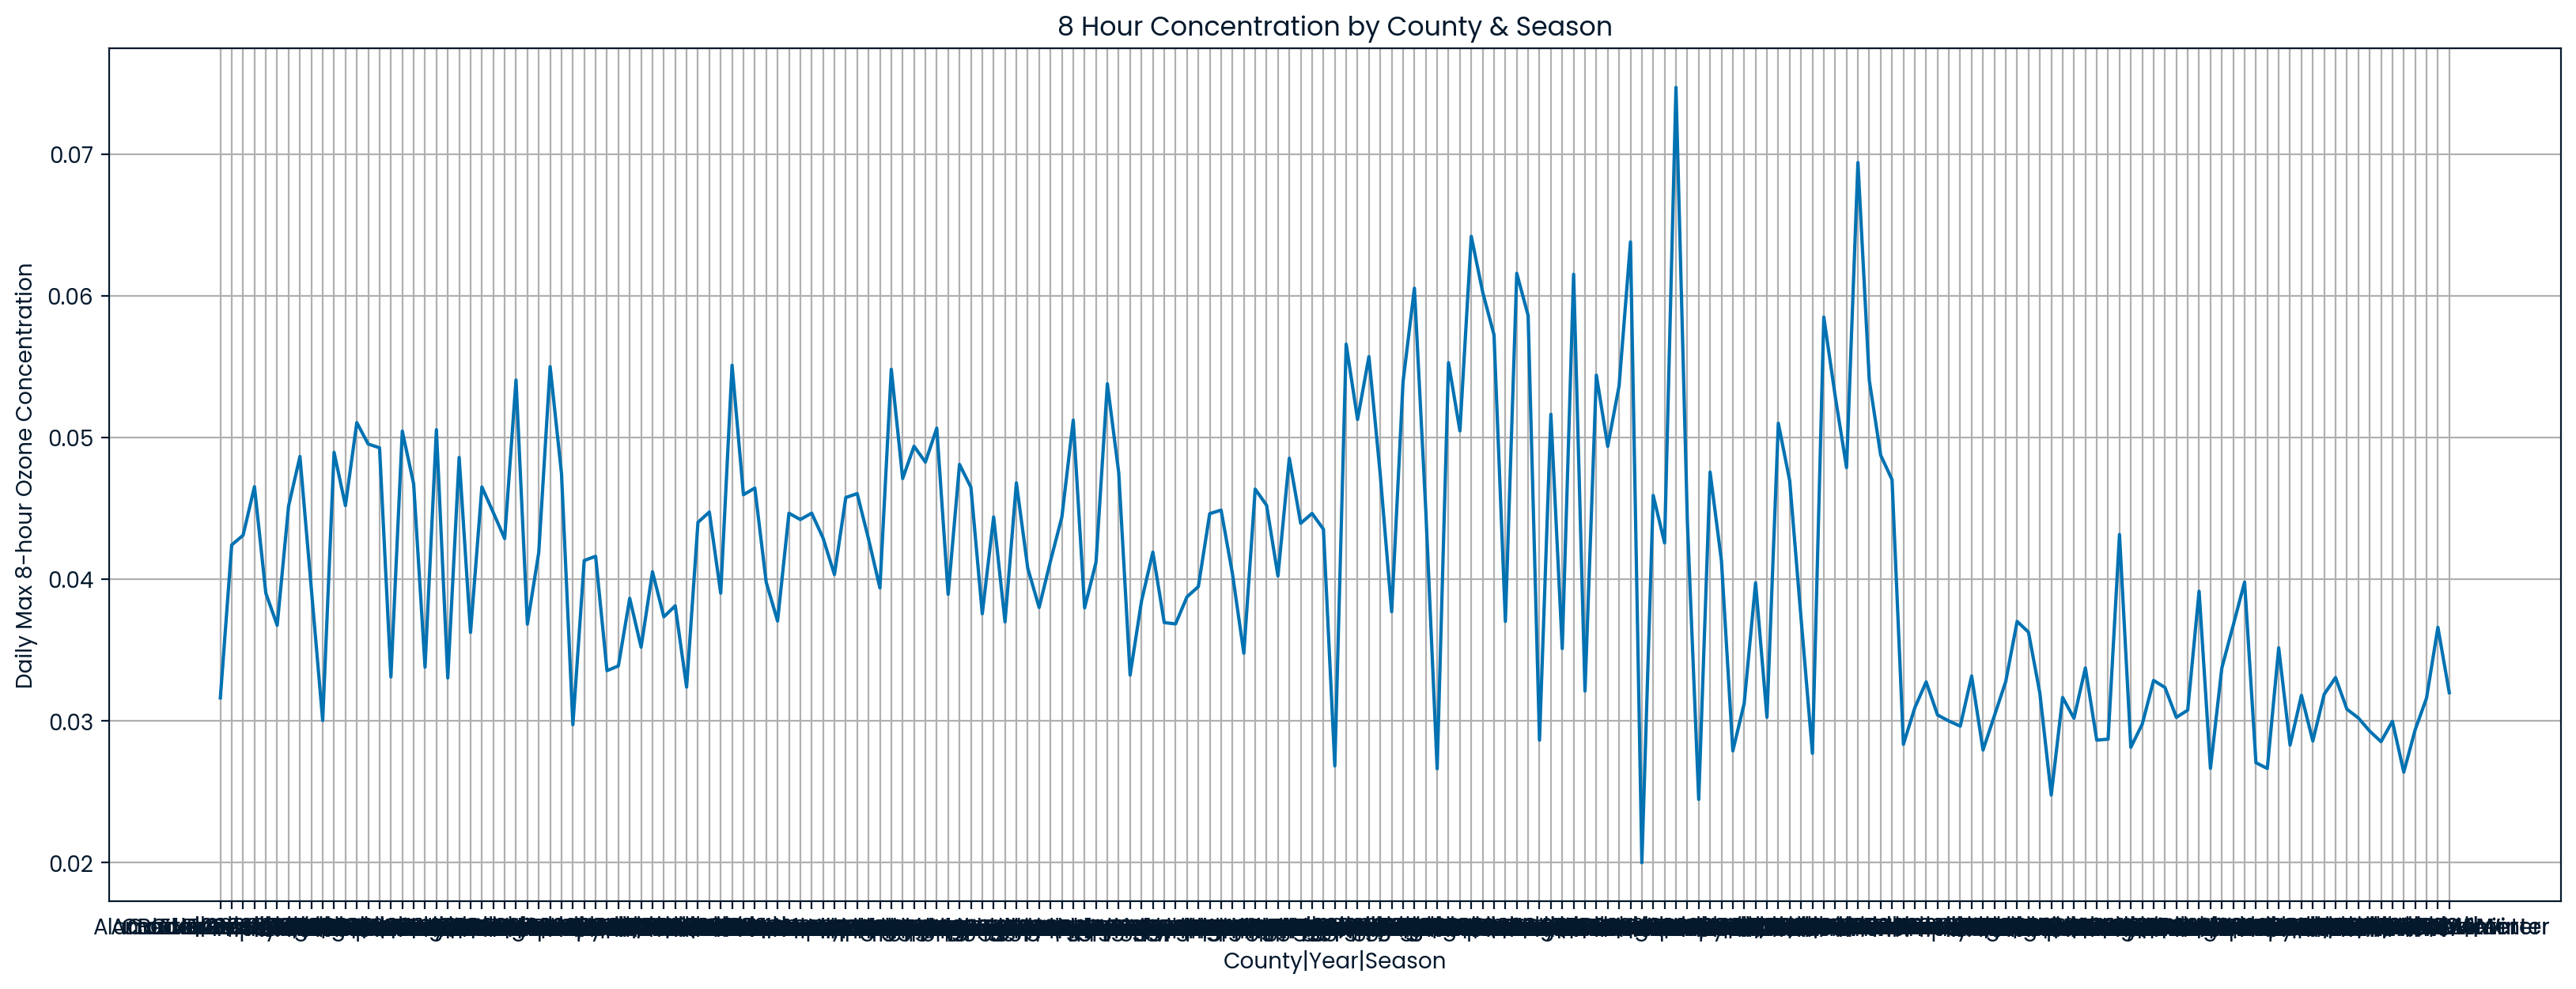

In [76]:
region_time_8hr=['County','Year','Season']
y=[ 'Daily Max 8-hour Ozone Concentration']
ozone=ozone.sort_values(by=['Year','Season','County'])
plot_and_df(ozone,'Daily Max 8-hour Ozone Concentration',region_time_8hr,sort=['Year','Season','County'],title='8 Hour Concentration by County & Season')

### the next line plot does not consider location. It only looks at weekly values  
### they are ordered in sequence  

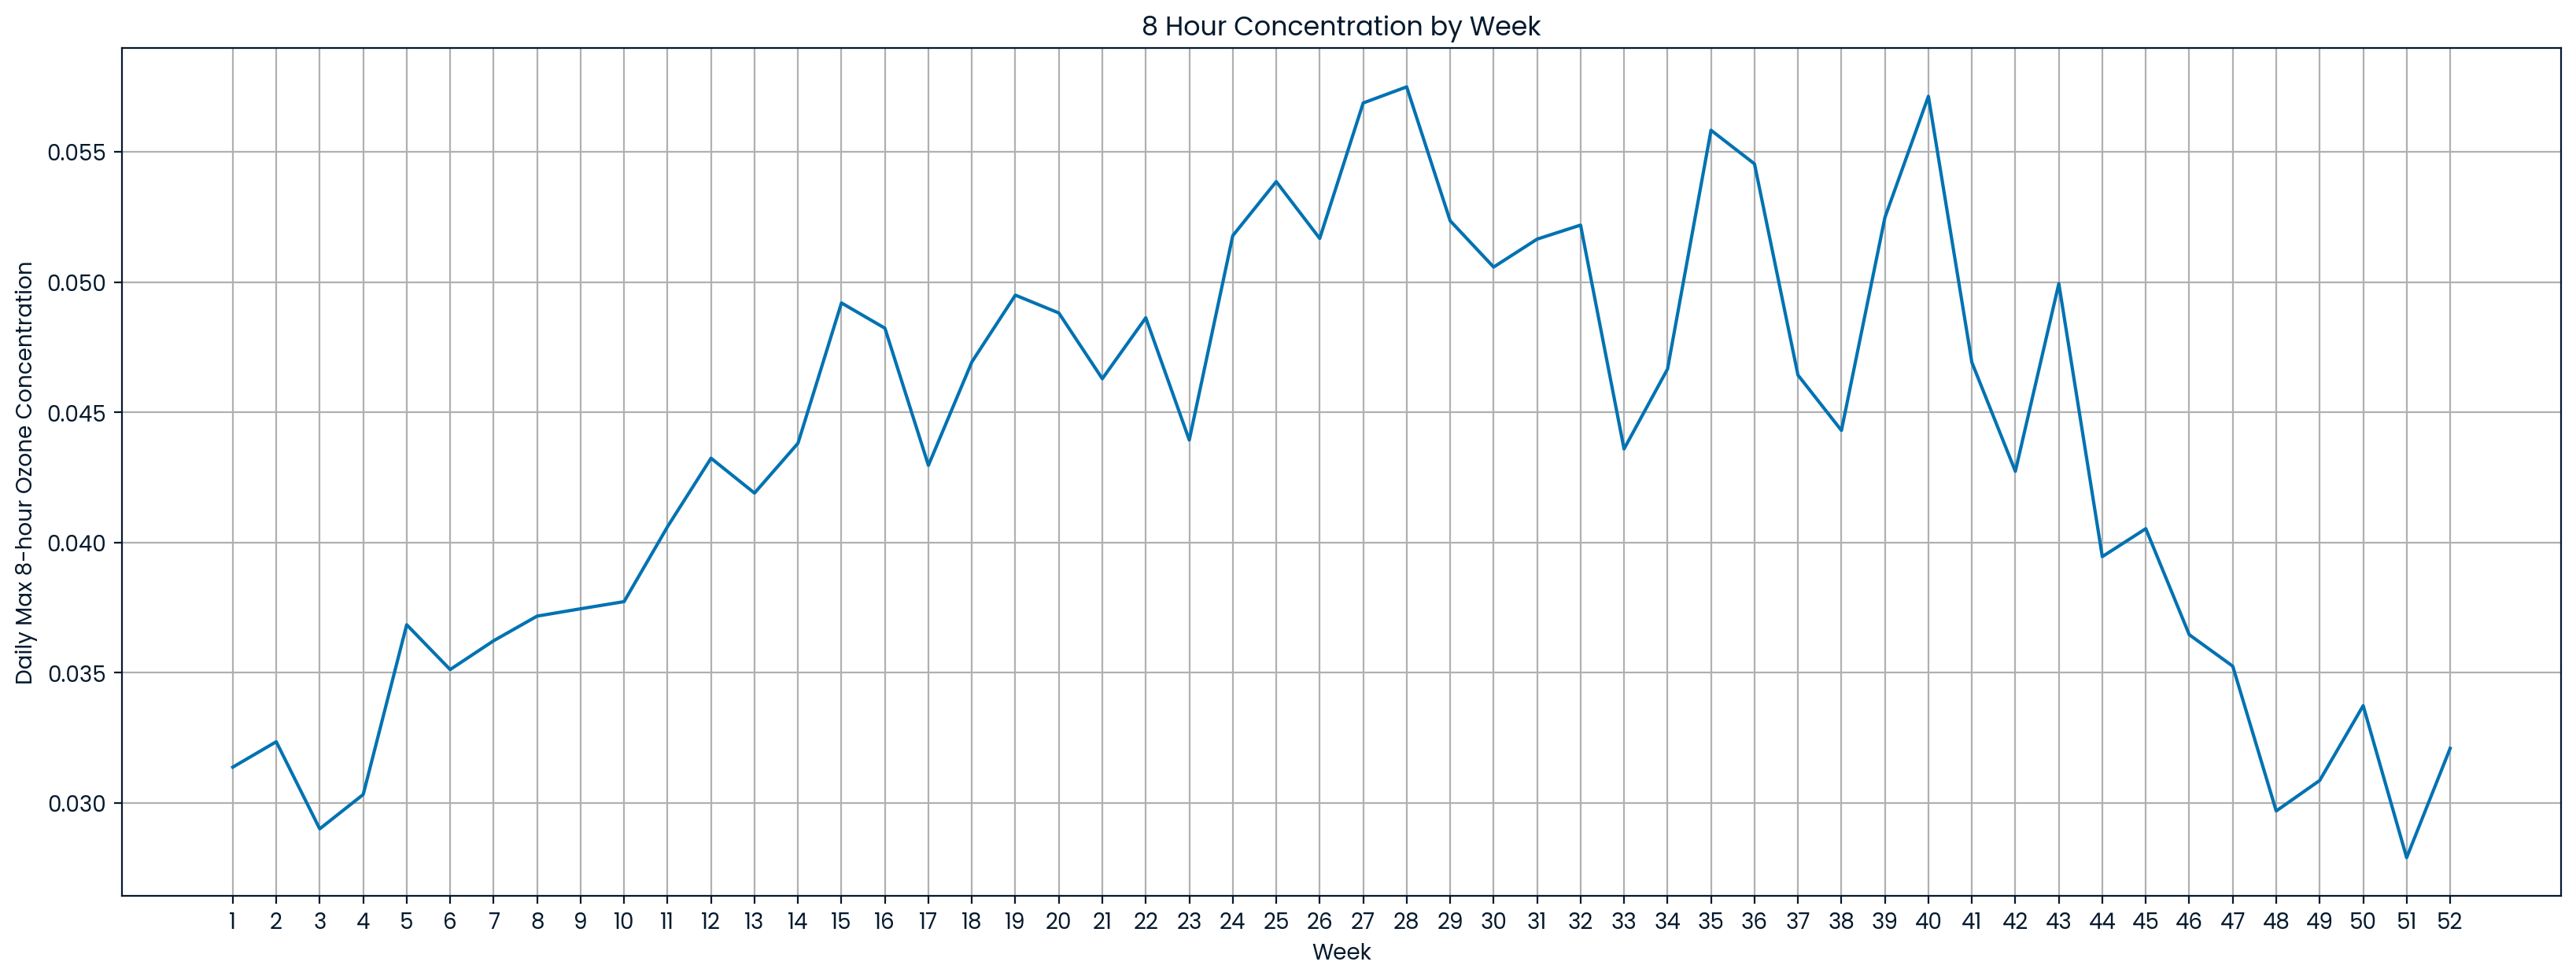

In [77]:
y=[ 'Daily Max 8-hour Ozone Concentration']
time_8hr=['Week']
ozone=ozone.sort_values(by='Week')
plot_and_df(ozone,'Daily Max 8-hour Ozone Concentration',time_8hr,sort=time_8hr,title='8 Hour Concentration by Week')

In [78]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [79]:
#load a saved version
df = pd.read_csv('mostly_cleaned_ozone.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Weekdays in July seem to be the worst

In [80]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ========== SEASONAL ==========
season_agg = df.groupby('Season')['Daily Max 8-hour Ozone Concentration'].agg(['mean', 'sem']).reset_index()
season_agg.rename(columns={'mean': 'Ozone', 'sem': 'Error'}, inplace=True)
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_agg['Season'] = pd.Categorical(season_agg['Season'], categories=season_order, ordered=True)
season_agg.sort_values('Season', inplace=True)

# ========== MONTHLY (SUMMER) ==========
summer_df = df[df['Season'] == 'Summer']
month_agg = summer_df.groupby('Month')['Daily Max 8-hour Ozone Concentration'].agg(['mean', 'sem']).reset_index()
month_agg.rename(columns={'mean': 'Ozone', 'sem': 'Error'}, inplace=True)
month_map = {6: 'June', 7: 'July', 8: 'August'}
month_agg['Month_Label'] = month_agg['Month'].map(month_map)
month_order = ['June', 'July', 'August']
month_agg['Month_Label'] = pd.Categorical(month_agg['Month_Label'], categories=month_order, ordered=True)
month_agg.sort_values('Month_Label', inplace=True)

# ========== WEEKDAY (JULY) ==========
july_df = df[df['Month'] == 7]
dow_agg = july_df.groupby('Day_of_Week')['Daily Max 8-hour Ozone Concentration'].agg(['mean', 'sem']).reset_index()
dow_agg.rename(columns={'mean': 'Ozone', 'sem': 'Error'}, inplace=True)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_agg['Day_of_Week'] = pd.Categorical(dow_agg['Day_of_Week'], categories=weekday_order, ordered=True)
dow_agg.sort_values('Day_of_Week', inplace=True)

# ========== SUBPLOTS ==========
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=[
        'Mean Max 8-hour Ozone by Season',
        'Summer: Mean Ozone by Month',
        'July: Mean Ozone by Day of Week'
    ],
    shared_yaxes=False,
    vertical_spacing=0.2
)

# Season subplot
fig.add_trace(go.Bar(
    x=season_agg['Season'],
    y=season_agg['Ozone'],
    error_y=dict(type='data', array=season_agg['Error']),
    name='Seasonal Ozone',
    hovertemplate='Season: %{x}<br>Ozone: %{y:.2f} ppb<br>Error: %{error_y:.2f}<extra></extra>'
), row=1, col=1)

# Month subplot
fig.add_trace(go.Bar(
    x=month_agg['Month_Label'],
    y=month_agg['Ozone'],
    error_y=dict(type='data', array=month_agg['Error']),
    name='Summer Months',
    hovertemplate='Month: %{x}<br>Ozone: %{y:.2f} ppb<br>Error: %{error_y:.2f}<extra></extra>'
), row=2, col=1)

# Weekday subplot
fig.add_trace(go.Bar(
    x=dow_agg['Day_of_Week'],
    y=dow_agg['Ozone'],
    error_y=dict(type='data', array=dow_agg['Error']),
    name='Weekday (July)',
    hovertemplate='Day: %{x}<br>Ozone: %{y:.2f} ppb<br>Error: %{error_y:.2f}<extra></extra>'
), row=3, col=1)

# Layout updates
fig.update_layout(
    height=1000, width=800,
    title='Ozone Concentration Breakdown',
    showlegend=False,
    margin=dict(t=80, r=40, l=40, b=80)
)

fig.show()

# Southern California looks bad and it turns out the three worst offenders are there  

In [81]:
import plotly.express as px

# Plot using scatter_mapbox
fig = px.scatter_mapbox(
    df,
    lat='Site Latitude',
    lon='Site Longitude',
    color='Daily Max 8-hour Ozone Concentration',
    size='Daily Max 8-hour Ozone Concentration',
    hover_name='Local Site Name',
    hover_data={'County': True, 'Site Latitude': False, 'Site Longitude': False},
    color_continuous_scale='YlOrRd',
    size_max=15,
    zoom=5,
    title='California Ozone Concentration by Site'
)

# Update mapbox style (uses open-source token)
fig.update_layout(
    mapbox_style='carto-positron',  # or 'open-street-map', 'white-bg', 'carto-darkmatter'
    margin=dict(t=50, r=20, l=20, b=20)
)

fig.show()

In [82]:
import pandas as pd
import plotly.graph_objects as go

# Filter to Summer data
summer_df = df[df['Season'] == 'Summer']

# Aggregate by site to get top 3 by mean ozone
top_sites = (
    summer_df.groupby('Local Site Name')['Daily Max 8-hour Ozone Concentration']
    .mean()
    .nlargest(3)
    .index
)

# Subset to top 3 sites
top_df = summer_df[summer_df['Local Site Name'].isin(top_sites)]

# Group by Site and Day_of_Week and calculate mean and std
summary = (
    top_df.groupby(['Local Site Name', 'Day_of_Week'])['Daily Max 8-hour Ozone Concentration']
    .agg(['mean', 'std'])
    .reset_index()
)

# Create bar chart traces for each site
fig = go.Figure()

for site in top_sites:
    site_data = summary[summary['Local Site Name'] == site]
    fig.add_trace(go.Bar(
        x=site_data['Day_of_Week'],
        y=site_data['mean'],
        name=site,
        error_y=dict(type='data', array=site_data['std'], visible=True)
    ))

# Beautify layout
fig.update_layout(
    title="Top 3 Sites: Ozone Concentration by Day (Summer)",
    barmode='group',
    xaxis_title="Day of Week",
    yaxis_title="Daily Max 8-hour Ozone Concentration (ppm)",
    legend_title="Local Site Name",
    template="plotly_white"
)

fig.show()


# Examine high means and low variance regions by two approaches:  
1) look at z-tests
2) optimize to find top_n  

# 7 Counties have significantly high means and significantly low standard deviations  
use z and f scores to find Method Codes with high means and low standard deviations  

The overall mean is 0.04356727072409479, the overall std is 0.0146124087926183


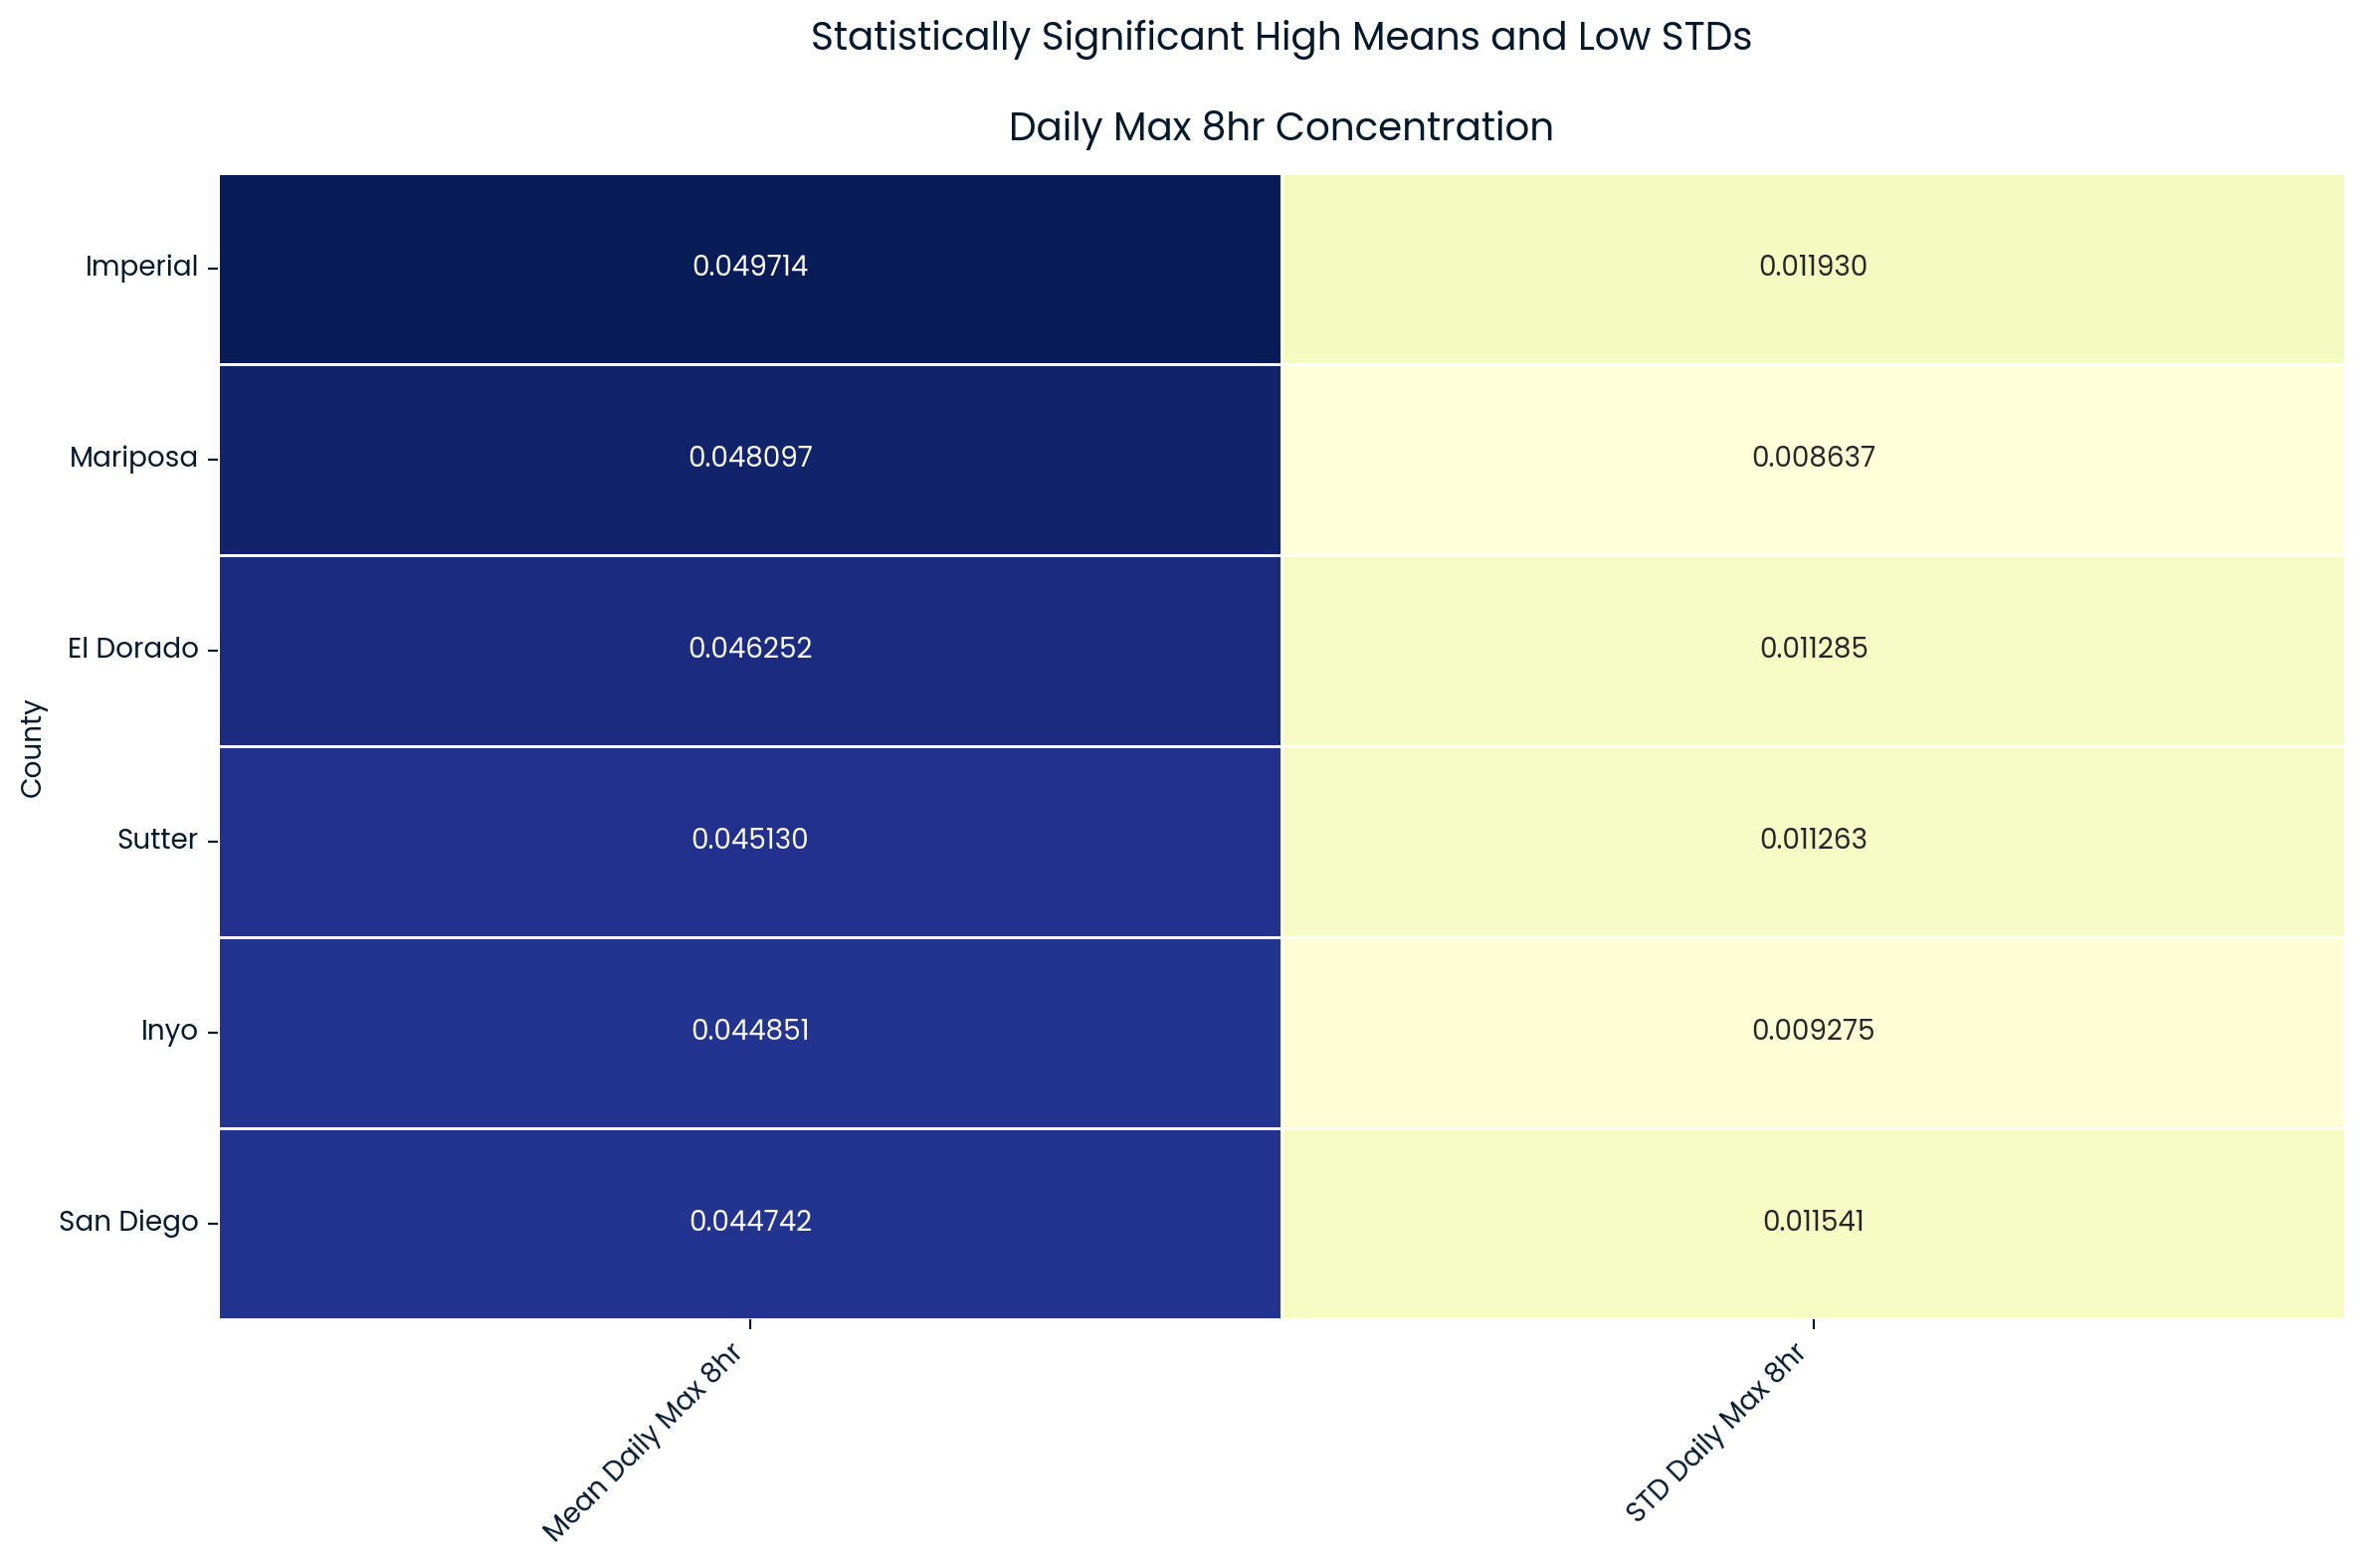

In [83]:

#Note: Merced-Coffee and Livermore are not adequatley represented
import pandas as pd
import numpy as np
from scipy.stats import norm

from scipy.stats import norm, f

# Overall stats
overall_mean = df['Daily Max 8-hour Ozone Concentration'].mean()
overall_var = df['Daily Max 8-hour Ozone Concentration'].var()
overall_n = df.shape[0]
print(f'The overall mean is {overall_mean}, the overall std is {np.sqrt(overall_var)}')

def analyze_group(group):
    n = group.shape[0]
    group_mean = group['Daily Max 8-hour Ozone Concentration'].mean()
    group_var = group['Daily Max 8-hour Ozone Concentration'].var()

    # Z-test for high mean (one-tailed)
    std_error = np.sqrt(overall_var / n)
    z_score = (group_mean - overall_mean) / std_error
    p_value_mean = 1 - norm.cdf(z_score)

    # F-test for low variance (one-tailed)
    f_stat = group_var / overall_var
    p_value_std = f.cdf(f_stat, dfn=n - 1, dfd=overall_n - 1)  # Lower tail: low variance

    # Flags
    high_mean = p_value_mean < 0.05  
    low_std = p_value_std < 0.05     # Significant low variance

    group['High Local Mean'] = high_mean
    group['Low Local Std'] = low_std

    return group


result_df = df.groupby(['County']).apply(analyze_group).reset_index(drop=True)
result_df=result_df.loc[(result_df['High Local Mean']==True)&(result_df['Low Local Std']==True)]
result_df=result_df.groupby(['County'],as_index=False)['Daily Max 8-hour Ozone Concentration'].agg(['mean','std']).rename(columns={'mean':'Mean Daily Max 8hr','std':'STD Daily Max 8hr'})
result_df=result_df.sort_values(by='Mean Daily Max 8hr',ascending=False).reset_index(drop=True)

#display(result_df)

import seaborn as sns
import matplotlib.pyplot as plt

# Set plot size to accommodate 32 rows and long float values
plt.figure(figsize=(12, 8))

# Create a copy of result_df with Local Site Name as index
heatmap_data = result_df.set_index('County')[['Mean Daily Max 8hr', 'STD Daily Max 8hr']]

# Round values to 6 decimals for annotation
rounded_data = heatmap_data.round(6)

# Generate the heatmap
sns.heatmap(
    rounded_data,
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar=False,
)

# Titles and layout tweaks
plt.title("Statistically Significant High Means and Low STDs\n\nDaily Max 8hr Concentration", fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [84]:
import plotly.express as px
locations=result_df['County']
plot_data=df.loc[df['County'].isin(locations)]
# Plot using scatter_mapbox
fig = px.scatter_mapbox(
    plot_data,
    lat='Site Latitude',
    lon='Site Longitude',
    color='Daily Max 8-hour Ozone Concentration',
    size='Daily Max 8-hour Ozone Concentration',
    hover_name='Local Site Name',
    hover_data={'County': True, 'Site Latitude': False, 'Site Longitude': False},
    color_continuous_scale='YlOrRd',
    size_max=15,
    zoom=5,
    title='Consistently High California Ozone Concentration'
)

# Update mapbox style (uses open-source token)
fig.update_layout(
    mapbox_style='carto-positron',  # or 'open-street-map', 'white-bg', 'carto-darkmatter'
    margin=dict(t=50, r=20, l=20, b=20)
)

fig.show()

# Same problem solved with machine learning  
reveals that 4 counties do not have both columns as statisticaly significant extremes together, but one or the other columns is so extreme that the weighted score places them higher than San Diego.  
They are:  
### Glenn, Yolo, San Benito, and Butte Counties

In [85]:
optimization_group=df.groupby(['County'],as_index=False)['Daily Max 8-hour Ozone Concentration'].agg(['mean','std'])
mn_std=optimization_group['std'].min()
mx_std=optimization_group['std'].max()
mn_mean=optimization_group['mean'].min()
mx_mean=optimization_group['mean'].max()
optimization_group['MinMax_mean']=(optimization_group['mean']-mn_mean)/(mx_mean-mn_mean)
optimization_group['MinMax_std']=(optimization_group['std']-mn_std)/(mx_std-mn_std)
optimization_group['Reversed_mnmx_std']=1+(optimization_group['MinMax_std']*-1)

In [86]:
optimization_group.head()


def f_of_omega(omega,col1,col2):
    return (omega*col1)+((1-omega)*col2)
    
    
def l_of_omega(omega,col1,col2):
    return 1/len(f_of_omega(omega,col1,col2))*sum((f_of_omega(omega,col1,col2)-np.mean(f_of_omega(omega,col1,col2)))**2)
    
def  find_omega(col1,col2,iterations=None):                                        
    if iterations: iterations=iterations  
    else: iterations = 1001
    omegas=np.linspace(0,1,iterations,endpoint=True)
    loss_record=[]
    for omega in omegas:
        loss_record.append(l_of_omega(omega,col1,col2))
    return omegas[np.argmin(loss_record)]
cola=optimization_group['Reversed_mnmx_std']
colb=optimization_group['MinMax_mean']
om=find_omega(cola,colb)
optimization_group['composite_std_mean']=f_of_omega(om,cola,colb)
optimization_group=optimization_group.sort_values(by='composite_std_mean',ascending=False)

In [87]:
optimization_group['composite_std_mean']=f_of_omega(om,cola,colb)
optimization_group=optimization_group.sort_values(by='composite_std_mean',ascending=False)

machine learning top 11

In [88]:
top_n=11
optimization_group[['County','mean','std']].head(top_n)

County      mean       std
19    Mariposa  0.048097  0.008637
11        Inyo  0.044851  0.009275
48     Ventura  0.044124  0.009069
10    Imperial  0.049714  0.011930
6    El Dorado  0.046252  0.011285
2        Butte  0.042826  0.009711
29  San Benito  0.039856  0.008532
44      Sutter  0.045130  0.011263
49        Yolo  0.040556  0.009201
8        Glenn  0.039407  0.008807
31   San Diego  0.044742  0.011541

In [89]:
df['Source_Cat']=(df['Source'] == 'AQS').astype(int)

# A look at Methods  


In [90]:
method_df=df.groupby('Method Code',as_index=False)['Daily Max 8-hour Ozone Concentration'].agg(['mean','sem']).rename(columns={'mean':'Mean Daily Max 8hr','sem':'Error Bar'})
method_df['Method Code']=method_df['Method Code'].astype(int).astype(str)
display(method_df.T.style.set_table_styles([ 
                       {"selector": ".col_heading","props":[("background-color", "#0E3AA8"), ("color", "white"),("border", "3px solid black")]},  
            {"selector": ".row_heading", "props": [("background-color", "#0E3AA8"), ("color", "white"),("border", "3px solid black")]}, 
            {"selector": "td", "props": [("background-color", "#4D7BED"), ("color", "white"),("border", "3px solid black")]}, 
            {"selector": "th.blank","props": [ ("background-color", "#0E3AA8"), ("color", "white"),("text-align", "center"),("border", "3px    solid black")]}]) )
import plotly.express as px
import pandas as pd



# 🎨 Create colorful bar plot with y-axis minimum
fig = px.bar(
    method_df,
    x='Method Code',
    y='Mean Daily Max 8hr',
    error_y='Error Bar',
    color='Method Code',
    color_discrete_sequence=px.colors.qualitative.Vivid,
    labels={'Mean Daily Max 8hr': 'Mean Max 8hr O₃'},
    title='Mean Daily Max 8hr by Method Code with SEM'
)

fig.update_layout(
    yaxis=dict(title='Mean Max 8hr O₃ (ppb)'),
    xaxis_title='Method Code',
    template='plotly_white',
    margin=dict(t=50, b=40, l=50, r=30)
)

fig.show()


# Hypothesis test:  
H(0) Method results are not significantly different  
H(1) Method results are significatly differnt  

In [91]:
import pandas as pd
from scipy import stats

def get_hyp_tests(meth_):
    # 🎯 Subset data
    sub_meth = df[df['new-methods'] == meth_]['Daily Max 8-hour Ozone Concentration']
    rest = df[df['new-methods'] != meth_]['Daily Max 8-hour Ozone Concentration']
    
    # 🧪 Two-sided t-test
    t_stat, p_value_two_sided = stats.ttest_ind(sub_meth, rest, equal_var=False)
    
    # ➗ Adjust for one-sided test based on direction
    if sub_meth.mean() > rest.mean():
        p_value_one_sided = p_value_two_sided / 2
        direction = "greater"
        hypothesis = f"H₁: Method {meth_} > Others"
    else:
        p_value_one_sided = p_value_two_sided / 2
        direction = "less"
        hypothesis = f"H₁: Method {meth_} < Others"
    
    # 📣 Print results
    print(f"\n🔍 Method Code: {meth_}")
    print(f"Mean of Method {meth_}: {sub_meth.mean():.3f}")
    print(f"Mean of other methods: {rest.mean():.3f}")
    print(f"One-sided p-value ({hypothesis}): {p_value_one_sided:.20f}")
    print(f"➡️ Interpretation: Method {meth_} is likely {direction} than others (p = {p_value_one_sided:.4g})")
df['new-methods']=df['Method Code'].apply(lambda x: str(int(x)) if x!=199 and x!=87 else '199 & 87')
# Run for all unique methods
for method in df['new-methods'].unique():
    get_hyp_tests(method)


🔍 Method Code: 47
Mean of Method 47: 0.039
Mean of other methods: 0.045
One-sided p-value (H₁: Method 47 < Others): 0.00000000000000000000
➡️ Interpretation: Method 47 is likely less than others (p = 0)

🔍 Method Code: 199 & 87
Mean of Method 199 & 87: 0.045
Mean of other methods: 0.040
One-sided p-value (H₁: Method 199 & 87 > Others): 0.00000000000000000000
➡️ Interpretation: Method 199 & 87 is likely greater than others (p = 7.045e-259)

🔍 Method Code: 53
Mean of Method 53: 0.060
Mean of other methods: 0.043
One-sided p-value (H₁: Method 53 > Others): 0.00000000000000000000
➡️ Interpretation: Method 53 is likely greater than others (p = 1.971e-70)


In [92]:
total_observations=df.shape[0]
for k,v in df['Method Code'].value_counts().items(): 
    print(f'Method Code: {k} accounts for {round(v/total_observations*100)}% of the data')

Method Code: 87.0 accounts for 68% of the data
Method Code: 47.0 accounts for 23% of the data
Method Code: 199.0 accounts for 8% of the data
Method Code: 53.0 accounts for 1% of the data
